Write out the synthetic spectra that fails in redrock. Fail here is defined as 
> fail = Fails dv criteria with ZWARN==0 (catastrophic failures)

For simplicity we only care about synthetic spectra with dark sky

In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat

In [45]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# read in GAMA-Legacy data
field = 'g15'
# read in GAMA-Legacy survey
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

In [4]:
# GAMA-Legacy object properties
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63004 galaxies total


In [5]:
i_block = 5
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])

f_i = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_gal = np.loadtxt(f_i, unpack=True, usecols=[0], dtype='i')

f_z = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdata = fits.open(f_z)[1].data

f_spec = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.fits'])
spec = read_spectra(f_spec)

In [6]:
print('%i synthetic spectra with redrock redshifts' % len(zdata['Z']))

1000 synthetic spectra with redrock redshifts


In [7]:
def GAMA_subsample(index, colour='C0', size=None): 
    ''' highlight the subsample in the color-magnitude and color-Halpha 
    relations of the entire GAMA sample
    '''
    if size is None: ss = 1.
    else: ss=size
    fig = plt.figure(figsize=(15, 4))
    ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, y, ylbl in zip(range(1,4), ys, ylbls):
        sub = fig.add_subplot(1,3,i)
        sub.scatter(r_absmag_gama, y, c='k', s=1.)
        sub.scatter(r_absmag_gama[index], y[index], c=colour, s=ss)
        if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
        sub.set_xlim([-14., -24])
        sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
        sub.set_ylim([-0.2, 1.6])
    fig.subplots_adjust(wspace=0.3)

    fig = plt.figure(figsize=(15, 4))
    xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
    xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
    for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
        sub = fig.add_subplot(1, len(xs), i)
        hasha = (gama_ha > 0)
        sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
        sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
        hasha = (gama_ha[index] > 0)
        sub.scatter(x[index][hasha], gama_ha[index][hasha], c=colour, s=ss)
        sub.scatter(x[index][~hasha], np.repeat(1e-2, np.sum(~hasha)), c=colour, s=ss)
        sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
        sub.set_xlim([-0.2, 2.])
        if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
        sub.set_ylim([5e-3, 2e4])
        sub.set_yscale('log')
    fig.subplots_adjust(wspace=0.3)
    return None 

Now lets classify the targets that redrock fails at

In [8]:
# for redrock (no archetype flag)
dz_1pz = np.abs(redshift[i_gal] - zdata['Z'])/(1.+redshift[i_gal])
dz_criterion = (dz_1pz < 0.003)
good = dz_criterion & (zdata['ZWARN'] == 0)
fail = ~dz_criterion & (zdata['ZWARN'] == 0)
miss = dz_criterion & (zdata['ZWARN'] != 0)
lost = ~dz_criterion & (zdata['ZWARN'] != 0)
print('n_targ, good, fail, miss, lost')
print('%i, %i, %i, %i, %i' % (len(i_gal), np.sum(good), np.sum(fail), np.sum(miss), np.sum(lost)))

n_targ, good, fail, miss, lost
1000, 968, 27, 0, 5


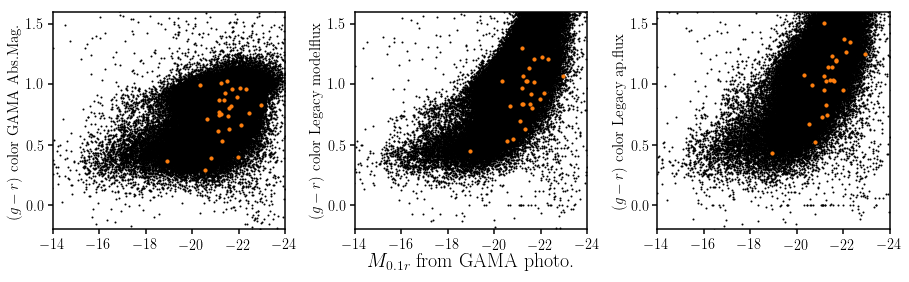

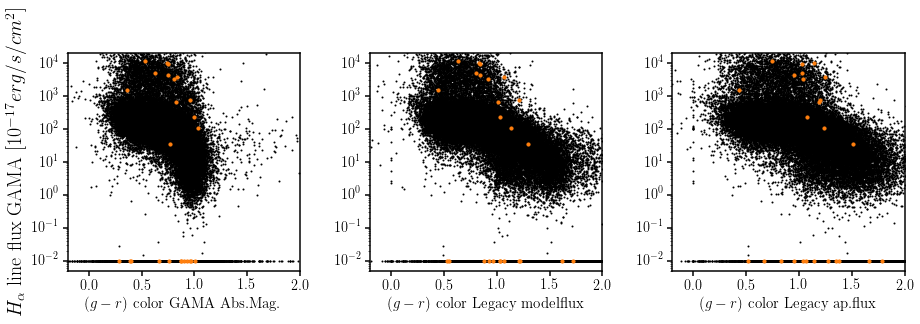

In [9]:
GAMA_subsample(i_gal[fail], colour='C1', size=10)

It's worth noting that out of the 27 failures

In [10]:
fail_strongHA = fail & (gama_ha[i_gal] > 1e3)
print('%i have strong emission lines' % np.sum(fail_strongHA))

10 have strong emission lines


In [11]:
spec_fail = spec.select(targets=np.arange(len(i_gal))[fail])
print('%i'% spec_fail.num_targets()) 

27


Now lets write these spectra out to file

In [12]:
# save indices for comparison to GAMA truth tables later
f_indx = ''.join([dir_spectra, 
                  'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.zfail.index'])
np.savetxt(f_indx, np.arange(ngal)[i_gal][fail], fmt='%i')

In [14]:
redshift[i_gal][fail]

array([0.113004  , 0.149487  , 0.187157  , 0.136221  , 0.15166102,
       0.12429902, 0.12562299, 0.13708402, 0.13229   , 0.13675798,
       0.25201   , 0.18944801, 0.4625903 , 0.12591   , 0.26064   ,
       0.10385401, 0.18193   , 0.38812   , 0.18461098, 0.18011   ,
       0.28366715, 0.187648  , 0.22141099, 0.140299  , 0.3918959 ,
       0.14246301, 0.135406  ], dtype=float32)

In [23]:
f_spec_fail = ''.join([dir_spectra, 
                       'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.zfail.fits'])
write_spectra(f_spec_fail, spec_fail)

'/Volumes/chang_eHDD/projects/feasiBGS/spectra/GamaLegacy.g15.expSpectra.darksky.seed1.exptime300.5of64blocks.zfail.fits'

I ran the redrock `fail` objects through redrock again

In [42]:
# regular redrock
rr0 = fits.open(''.join([dir_redrock, 
                'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.zfail.redrock.fits']))[1].data
# redrock -- archetype
rr1 = fits.open(''.join([dir_redrock, 
                'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.zfail.redrock.archetype.fits']))[1].data
# redrock -- archetype w/ updated template 
rr2 = fits.open(''.join([dir_redrock, 
                'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.zfail.redrock.archetype.newgaltemp.fits']))[1].data

In [43]:
z_true = redshift[i_gal][fail]

(0.0, 1.2)

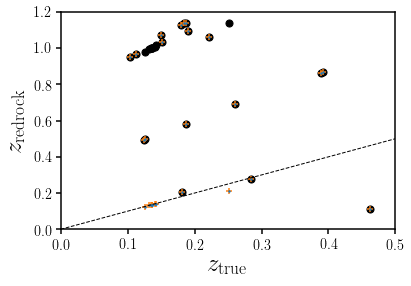

In [57]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(z_true, rr0['Z'], c='k', s=50, label='Redrock')
sub.scatter(z_true, rr1['Z'], c='C1', marker='+', label='Redrock --archetype')
sub.scatter(z_true, rr1['Z'], c='C0', s=2, label='Redrock --archetype rrtemplate')
sub.plot([0., 1.2], [0., 1.2], c='k', ls='--', lw=1)
sub.set_xlabel('$z_\mathrm{true}$', fontsize=25)
sub.set_xlim([0., 0.5])
sub.set_ylabel('$z_\mathrm{redrock}$', fontsize=25)
sub.set_ylim([0., 1.2])

In [ ]:
sub